# Arrest Intensity Fairness Audit

Analysis of everything.

In [17]:
ARRESTS_CSV    = "NYPD_Arrests_Data_(Historic)_20251028.csv"
COMPLAINTS_CSV = "NYPD_Complaint_Data_Historic_20251028.csv"
# If/when you add 311 and precinct polygons, we’ll plug those here.
# PRECINCTS_CSV  = "data/raw/Police_Precincts_20251028.csv"
# SR311_CSV      = "data/raw/311_Service_Requests_2010_present_subset.csv"

DATE_MIN = "2020-01-01"   # EDIT date window if you want
DATE_MAX = "2024-01-01"

# If you want to narrow to offence categories, list them here (upper-case, see data for exact values).
# Leave as None to include ALL offences.
OFFENSE_WHITELIST = None  # e.g., {"DISORDERLY CONDUCT","ALCOHOLIC BEVERAGE CONTROL LAW"}

import pandas as pd
import numpy as np

pd.options.display.max_rows = 10
pd.options.display.width = 120


In [18]:
usecols_arrests = [
    "ARREST_DATE","ARREST_PRECINCT","OFNS_DESC","LAW_CAT_CD","PERP_RACE","PERP_SEX"
]

def load_arrests(path, date_min, date_max, offense_whitelist=None):
    df = pd.read_csv(path, usecols=[c for c in usecols_arrests if c in pd.read_csv(path, nrows=0).columns])
    # Dates
    df["ARREST_DATE"] = pd.to_datetime(df["ARREST_DATE"], errors="coerce")
    df = df.dropna(subset=["ARREST_DATE"])
    mask = (df["ARREST_DATE"]>=date_min) & (df["ARREST_DATE"]<date_max)
    df = df.loc[mask].copy()
    # Precinct
    df["ARREST_PRECINCT"] = pd.to_numeric(df["ARREST_PRECINCT"], errors="coerce").astype("Int64")
    df = df.dropna(subset=["ARREST_PRECINCT"]).copy()
    df["ARREST_PRECINCT"] = df["ARREST_PRECINCT"].astype(int)
    # Offence text tidy
    if "OFNS_DESC" in df.columns:
        df["OFNS_DESC"] = df["OFNS_DESC"].astype(str).str.upper().str.strip()
    if offense_whitelist is not None:
        df = df[df["OFNS_DESC"].isin({o.upper() for o in offense_whitelist})].copy()
    # Month key
    df["month"] = df["ARREST_DATE"].dt.to_period("M").dt.to_timestamp("M")
    return df

arrests = load_arrests(ARRESTS_CSV, DATE_MIN, DATE_MAX, OFFENSE_WHITELIST)
arrests.head()

,ARREST_DATE,OFNS_DESC,LAW_CAT_CD,ARREST_PRECINCT,PERP_SEX,PERP_RACE,month
260503,2023-12-31,OFF. AGNST PUB ORD SENSBLTY &,M,40,M,WHITE HISPANIC,2023-12-31
260504,2023-12-31,CRIMINAL MISCHIEF & RELATED OF,F,24,M,BLACK,2023-12-31
260505,2023-12-31,DANGEROUS WEAPONS,F,73,M,BLACK,2023-12-31
260506,2023-12-31,OFF. AGNST PUB ORD SENSBLTY &,M,40,M,BLACK,2023-12-31
260507,2023-12-31,MISCELLANEOUS PENAL LAW,F,41,M,BLACK HISPANIC,2023-12-31


In [19]:
usecols_complaints = [
    "CMPLNT_FR_DT","ADDR_PCT_CD","OFNS_DESC","PD_DESC","LAW_CAT_CD"
]

def load_complaints(path, date_min, date_max, offense_whitelist=None):
    df = pd.read_csv(path, usecols=[c for c in usecols_complaints if c in pd.read_csv(path, nrows=0).columns])
    # Dates
    df["CMPLNT_FR_DT"] = pd.to_datetime(df["CMPLNT_FR_DT"], errors="coerce")
    df = df.dropna(subset=["CMPLNT_FR_DT"])
    mask = (df["CMPLNT_FR_DT"]>=date_min) & (df["CMPLNT_FR_DT"]<date_max)
    df = df.loc[mask].copy()
    # Precinct
    df["ADDR_PCT_CD"] = pd.to_numeric(df["ADDR_PCT_CD"], errors="coerce").astype("Int64")
    df = df.dropna(subset=["ADDR_PCT_CD"]).copy()
    df["ADDR_PCT_CD"] = df["ADDR_PCT_CD"].astype(int)
    # Offence tidy: prefer OFNS_DESC; fallback to PD_DESC
    if "OFNS_DESC" in df.columns:
        df["OFNS_DESC"] = df["OFNS_DESC"].astype(str).str.upper().str.strip()
    if "PD_DESC" in df.columns:
        df["PD_DESC"] = df["PD_DESC"].astype(str).str.upper().str.strip()
        df["OFFENSE_BEST"] = np.where(df["OFNS_DESC"].notna() & (df["OFNS_DESC"]!="NAN"), df["OFNS_DESC"], df["PD_DESC"])
    else:
        df["OFFENSE_BEST"] = df["OFNS_DESC"]
    if offense_whitelist is not None:
        df = df[df["OFFENSE_BEST"].isin({o.upper() for o in offense_whitelist})].copy()
    # Month key
    df["month"] = df["CMPLNT_FR_DT"].dt.to_period("M").dt.to_timestamp("M")
    return df

complaints = load_complaints(COMPLAINTS_CSV, DATE_MIN, DATE_MAX, OFFENSE_WHITELIST)
complaints.head()


,CMPLNT_FR_DT,ADDR_PCT_CD,OFNS_DESC,PD_DESC,LAW_CAT_CD,OFFENSE_BEST,month
68,2021-09-05,18,SEX CRIMES,"SEXUAL ABUSE 3,2",MISDEMEANOR,SEX CRIMES,2021-09-30
163,2023-08-14,121,PETIT LARCENY,"LARCENY,PETIT OF LICENSE PLATE",MISDEMEANOR,PETIT LARCENY,2023-08-31
413,2022-03-13,113,SEX CRIMES,SEXUAL ABUSE,FELONY,SEX CRIMES,2022-03-31
537,2022-09-05,43,FORGERY,"FORGERY,ETC.,UNCLASSIFIED-FELO",FELONY,FORGERY,2022-09-30
717,2021-12-29,106,CRIMINAL MISCHIEF & RELATED OF,"CRIMINAL MISCHIEF,UNCLASSIFIED 4",MISDEMEANOR,CRIMINAL MISCHIEF & RELATED OF,2021-12-31


In [20]:
# EDIT: extend/adjust as you see actual values in your data (print value_counts to inspect).
CROSSWALK = {
    "DISORDERLY CONDUCT": "PUBLIC ORDER",
    "ALCOHOLIC BEVERAGE CONTROL LAW": "PUBLIC ORDER",
    "OFF. AGNST PUB ORD SENSBLTY & RGHTS": "PUBLIC ORDER",
    # Add more mappings...
}

def apply_crosswalk(series, crosswalk):
    s = series.fillna("").astype(str).str.upper().str.strip()
    return s.map(crosswalk).fillna("OTHER")

if OFFENSE_WHITELIST is None:
    arrests["category"]   = apply_crosswalk(arrests["OFNS_DESC"], CROSSWALK)
    complaints["category"]= apply_crosswalk(complaints["OFFENSE_BEST"], CROSSWALK)
else:
    arrests["category"]   = arrests["OFNS_DESC"]
    complaints["category"]= complaints["OFFENSE_BEST"]

arrests["category"].value_counts().head(10), complaints["category"].value_counts().head(10)

(category
 OTHER           711530
 PUBLIC ORDER      1036
 Name: count, dtype: int64,
 category
 OTHER           1946952
 PUBLIC ORDER        374
 Name: count, dtype: int64)

In [21]:
# Arrests by precinct-month-category
ar_agg = (arrests
          .groupby(["ARREST_PRECINCT","month","category"], as_index=False)
          .size()
          .rename(columns={"size":"arrests"}))

# Complaints by precinct-month-category
co_agg = (complaints
          .groupby(["ADDR_PCT_CD","month","category"], as_index=False)
          .size()
          .rename(columns={"size":"complaints","ADDR_PCT_CD":"precinct"}))

# Align arrests column names
ar_agg = ar_agg.rename(columns={"ARREST_PRECINCT":"precinct"})

# Merge and compute AII (arrests per complaint) with small epsilon
EPS = 1e-9
panel = (ar_agg
         .merge(co_agg, on=["precinct","month","category"], how="outer")
         .fillna({"arrests":0,"complaints":0}))
panel["AII_nypd"] = panel["arrests"] / (panel["complaints"] + EPS)

panel.head()

,precinct,month,category,arrests,complaints,AII_nypd
0,1,2020-01-31,OTHER,199.0,586.0,3.395904e-01
1,1,2020-01-31,PUBLIC ORDER,2.0,0.0,2.000000e+09
2,1,2020-02-29,OTHER,177.0,549.0,3.224044e-01
3,1,2020-03-31,OTHER,158.0,347.0,4.553314e-01
4,1,2020-04-30,OTHER,63.0,175.0,3.600000e-01


In [22]:
# --- New Cell: filter low exposure and recompute AII ---
MIN_COMPLAINTS = 5  # adjust to 3–10 if needed, but state it in ETHICS.md

panel_filt = panel[panel["complaints"] >= MIN_COMPLAINTS].copy()
panel_filt["AII_nypd"] = panel_filt["arrests"] / panel_filt["complaints"]

# (optional) cap extreme AII values only for plotting
p99 = panel_filt["AII_nypd"].quantile(0.99)
panel_filt["AII_plot"] = panel_filt["AII_nypd"].clip(upper=p99)

In [38]:
precinct_summary = (panel_filt.groupby("precinct", as_index=False)
    .agg(median_AII=("AII_nypd","median"),
         iqr_AII=("AII_nypd", lambda s: s.quantile(0.75)-s.quantile(0.25)),
         months=("AII_nypd","size")))


display(precinct_summary.sort_values("median_AII", ascending=False).head(10))
display(precinct_summary.sort_values("median_AII", ascending=True).head(10))

,precinct,median_AII,iqr_AII,months
1,5,0.650411,0.138877,48
7,14,0.495743,0.091465,48
53,84,0.487579,0.103529,48
60,103,0.481420,0.121574,48
70,113,0.478463,0.116085,48
73,120,0.466791,0.106269,48
23,41,0.459059,0.071738,48
22,40,0.454098,0.106988,48
15,25,0.450581,0.147734,48
26,44,0.449888,0.092759,48


,precinct,median_AII,iqr_AII,months
12,22,0.206897,0.182576,47
68,111,0.211905,0.058134,48
10,19,0.217453,0.058647,48
8,17,0.253711,0.064971,48
36,62,0.268892,0.073067,48
11,20,0.269453,0.072887,48
0,1,0.269531,0.073510,48
65,108,0.269609,0.050989,48
56,94,0.270146,0.095710,48
49,78,0.273046,0.105804,48


In [24]:
import numpy as np, pandas as pd, statsmodels.api as sm

mod = panel_filt.copy()
mod["month_str"] = pd.to_datetime(mod["month"]).dt.to_period("M").astype(str)
mod["precinct"]  = mod["precinct"].astype(int).astype(str)
mod["category"]  = mod["category"].astype(str)

X = pd.get_dummies(mod[["precinct","month_str","category"]], drop_first=True, dtype=float)
y = mod["arrests"].astype(float).to_numpy()
offset = np.log(mod["complaints"].astype(float).to_numpy())

X = sm.add_constant(X, has_constant="add")

# quick Poisson to get dispersion, then NB
pois = sm.GLM(y, X, family=sm.families.Poisson(), offset=offset).fit()
mu = pois.mu
pearson = ((y - mu)**2 / mu).sum()
alpha = max(1e-8, (pearson - pois.df_resid) / np.sum(mu**2))

nb = sm.GLM(y, X, family=sm.families.NegativeBinomial(alpha=alpha), offset=offset)
nb_res = nb.fit(cov_type="cluster", cov_kwds={"groups": mod["precinct"]})
print("NB alpha (mom):", alpha)
print(nb_res.summary().as_text())

# precinct effects as rate ratios
prec_cols = [c for c in X.columns if c.startswith("precinct_")]
eff = nb_res.params[prec_cols]
ci  = nb_res.conf_int().loc[prec_cols]
adj_nb = pd.DataFrame({
    "precinct":[c.split("_",1)[1] for c in prec_cols],
    "adj_log_rate":eff.values,
    "adj_log_rate_lo":ci[0].values,
    "adj_log_rate_hi":ci[1].values
})
adj_nb["adj_rate_ratio"]    = np.exp(adj_nb["adj_log_rate"])
adj_nb["adj_rate_ratio_lo"] = np.exp(adj_nb["adj_log_rate_lo"])
adj_nb["adj_rate_ratio_hi"] = np.exp(adj_nb["adj_log_rate_hi"])

adj_nb.sort_values("adj_rate_ratio", ascending=False).head(10)

NB alpha (mom): 4.876926806262062e-05
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 3703
Model:                            GLM   Df Residuals:                     3578
Model Family:        NegativeBinomial   Df Model:                          124
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18822.
Date:                Wed, 29 Oct 2025   Deviance:                       11996.
Time:                        18:56:35   Pearson chi2:                 1.22e+04
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:              cluster                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------

,precinct,adj_log_rate,adj_log_rate_lo,adj_log_rate_hi,adj_rate_ratio,adj_rate_ratio_lo,adj_rate_ratio_hi
47,5,0.902122,0.900936,0.903307,2.464827,2.461906,2.467751
14,113,0.617389,0.615347,0.619431,1.854081,1.850299,1.857870
22,14,0.588652,0.588129,0.589175,1.801558,1.800616,1.802501
4,103,0.580576,0.579435,0.581716,1.787067,1.785030,1.789106
71,84,0.564355,0.563366,0.565344,1.758313,1.756576,1.760052
17,120,0.540352,0.539368,0.541337,1.716612,1.714922,1.718303
30,25,0.535980,0.534572,0.537388,1.709122,1.706717,1.711531
41,44,0.531490,0.530225,0.532754,1.701465,1.699315,1.703618
38,41,0.530465,0.529252,0.531679,1.699723,1.697661,1.701787
37,40,0.528471,0.526764,0.530178,1.696337,1.693443,1.699235


In [25]:
print("y dtype:", y.dtype, "has any object?", isinstance(y, object))
print("offset dtype:", offset.dtype)
print("X dtypes (unique):", set(str(dt) for dt in X.dtypes.unique()))
print("Any object dtypes in X?", any(dt == 'object' for dt in X.dtypes))
print("Rows, Cols:", X.shape)
print("Non-finite in y/offset:", np.isfinite(y).all(), np.isfinite(offset).all())

y dtype: float64 has any object? True
offset dtype: float64
X dtypes (unique): {'float64'}
Any object dtypes in X? False
Rows, Cols: (3703, 125)
Non-finite in y/offset: True True


In [26]:
TARGET_PCT = int(precinct_summary.sort_values("median_AII", ascending=False).iloc[0]["precinct"])

pct_ts = (panel_filt[panel_filt["precinct"]==TARGET_PCT]
          .groupby("month", as_index=False)
          .agg(arrests=("arrests","sum"),
               complaints=("complaints","sum")))
pct_ts["AII_nypd"] = pct_ts["arrests"] / pct_ts["complaints"]

In [27]:
from pathlib import Path
OUT = Path("reports"); FIG = OUT/"figures"; TAB = OUT/"tables"
for p in (OUT, FIG, TAB): p.mkdir(parents=True, exist_ok=True)

# save filtered panel + summaries + model
panel_out = panel_filt.copy()
panel_out["month"] = pd.to_datetime(panel_out["month"]).dt.to_period("M").astype(str)
panel_out.to_csv(OUT/"precinct_month_category_panel_filtered.csv", index=False)
precinct_summary.to_csv(OUT/"precinct_summary_AII_median.csv", index=False)
if "adj_nb" in globals():
    adj_nb.to_csv(OUT/"precinct_adjusted_rate_ratios_NB_cluster.csv", index=False)

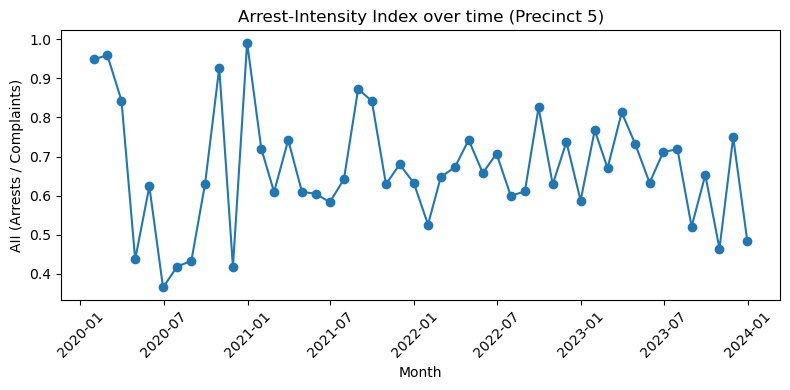

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(pct_ts["month"], pct_ts["AII_nypd"], marker="o")
plt.title(f"Arrest-Intensity Index over time (Precinct {TARGET_PCT})")
plt.xlabel("Month")
plt.ylabel("AII (Arrests / Complaints)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

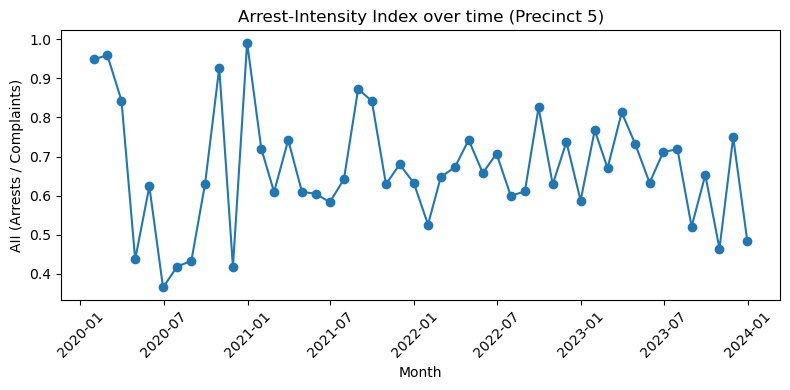

In [29]:
from pathlib import Path

# Create output folders if they don't exist
OUT = Path("reports")
FIG = OUT / "figures"
TAB = OUT / "tables"
for p in (OUT, FIG, TAB):
    p.mkdir(parents=True, exist_ok=True)

# (Optional) make month column a clean string for CSVs
panel_out = panel.copy()
if "month" in panel_out.columns:
    try:
        panel_out["month"] = pd.to_datetime(panel_out["month"]).dt.to_period("M").astype(str)
    except Exception:
        pass  # if it's already a string, ignore
    
# Panel used for plots/tables
panel_out.to_csv(OUT / "precinct_month_category_panel.csv", index=False)

# Precinct summary table
precinct_summary.to_csv(OUT / "precinct_summary_AII.csv", index=False)

# Model-adjusted precinct effects (only if you ran step 6 successfully)
if "adj_effects" in globals():
    adj_effects.to_csv(OUT / "precinct_adjusted_rate_ratios.csv", index=False)
    
    
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(pct_ts["month"], pct_ts["AII_nypd"], marker="o")
plt.title(f"Arrest-Intensity Index over time (Precinct {TARGET_PCT})")
plt.xlabel("Month"); plt.ylabel("AII (Arrests / Complaints)")
plt.xticks(rotation=45); plt.tight_layout()
plt.savefig(FIG / f"pct_{TARGET_PCT}_AII_timeseries.png", dpi=150)
plt.show()

In [36]:
## A) DATA INTEGRITY CHECKS
def integrity_report(arrests, complaints):
    rep = {}
    rep["arrests_rows"] = len(arrests)
    rep["complaints_rows"] = len(complaints)
    if "ARREST_KEY" in arrests.columns:
        rep["arrests_dupe_keys"] = arrests["ARREST_KEY"].duplicated().sum()
    if "CMPLNT_NUM" in complaints.columns:
        rep["complaints_dupe_keys"] = complaints["CMPLNT_NUM"].duplicated().sum()
    # share of rows with missing precinct/date
    rep["arrests_missing_pct"] = arrests["ARREST_PRECINCT"].isna().mean()
    rep["complaints_missing_pct"] = complaints["ADDR_PCT_CD"].isna().mean()
    # coverage by month (nonzero counts)
    ar_cov = arrests.groupby(arrests["ARREST_DATE"].dt.to_period("M")).size()
    co_cov = complaints.groupby(complaints["CMPLNT_FR_DT"].dt.to_period("M")).size()
    rep["arrests_months"] = ar_cov.index.astype(str).tolist()[:3] + ["..."]
    rep["complaints_months"] = co_cov.index.astype(str).tolist()[:3] + ["..."]
    return rep

integrity_report(arrests, complaints)

{'arrests_rows': 712566,
 'complaints_rows': 1947326,
 'arrests_missing_pct': 0.0,
 'complaints_missing_pct': 0.0,
 'arrests_months': ['2020-01', '2020-02', '2020-03', '...'],
 'complaints_months': ['2020-01', '2020-02', '2020-03', '...']}

In [39]:
## 1) DATA-DRIVEN OFFENSE GROUPS (no new data)
topN = 12  # tune until each group has decent counts
top_off = (complaints["OFFENSE_BEST"].astype(str).str.upper().value_counts()
           .head(topN).index)

def offense_group(s):
    return s.astype(str).str.upper().where(lambda x: x.isin(top_off), other="OTHER")

arrests["off_grp"]    = offense_group(arrests["OFNS_DESC"])
complaints["off_grp"] = offense_group(complaints["OFFENSE_BEST"])

# rebuild panel using off_grp instead of 'category'
ar2 = (arrests.groupby(["ARREST_PRECINCT","month","off_grp"], as_index=False)
              .size().rename(columns={"size":"arrests","ARREST_PRECINCT":"precinct"}))
co2 = (complaints.groupby(["ADDR_PCT_CD","month","off_grp"], as_index=False)
               .size().rename(columns={"size":"complaints","ADDR_PCT_CD":"precinct"}))
panel2 = (ar2.merge(co2, on=["precinct","month","off_grp"], how="outer")
              .fillna({"arrests":0,"complaints":0}))
panel2 = panel2[panel2["complaints"]>=5].copy()
panel2["AII_nypd"] = panel2["arrests"]/panel2["complaints"]

# Which offense families show the highest AII citywide?
(panel2.groupby("off_grp")["AII_nypd"].median()
 .sort_values(ascending=False).head(12))

off_grp
OTHER                             0.941556
MISCELLANEOUS PENAL LAW           0.750000
FELONY ASSAULT                    0.718750
ROBBERY                           0.565217
ASSAULT 3 & RELATED OFFENSES      0.562500
                                    ...   
CRIMINAL MISCHIEF & RELATED OF    0.202020
OFF. AGNST PUB ORD SENSBLTY &     0.181818
GRAND LARCENY                     0.152174
PETIT LARCENY                     0.134328
GRAND LARCENY OF MOTOR VEHICLE    0.076923
Name: AII_nypd, Length: 12, dtype: float64

In [40]:
## 2) NB + OFFSET with offense groups
import statsmodels.api as sm
mod2 = panel2.copy()
mod2["month_str"] = pd.to_datetime(mod2["month"]).dt.to_period("M").astype(str)
mod2["precinct"]  = mod2["precinct"].astype(int).astype(str)
mod2["off_grp"]   = mod2["off_grp"].astype(str)

X2 = pd.get_dummies(mod2[["precinct","month_str","off_grp"]], drop_first=True, dtype=float)
y2 = mod2["arrests"].astype(float).to_numpy()
off2 = np.log(mod2["complaints"].astype(float).to_numpy())
X2  = sm.add_constant(X2, has_constant="add")

pois2 = sm.GLM(y2, X2, family=sm.families.Poisson(), offset=off2).fit()
mu2   = pois2.mu
alpha2= max(1e-8, (((y2-mu2)**2/mu2).sum() - pois2.df_resid) / np.sum(mu2**2))

nb2   = sm.GLM(y2, X2, family=sm.families.NegativeBinomial(alpha=alpha2), offset=off2)
nb2r  = nb2.fit(cov_type="cluster", cov_kwds={"groups": mod2["precinct"]})
print(nb2r.summary().as_text())

# precinct adjusted rate ratios under offense-group controls
pcols = [c for c in X2.columns if c.startswith("precinct_")]
eff2  = nb2r.params[pcols]; ci2 = nb2r.conf_int().loc[pcols]
adj_nb2 = pd.DataFrame({
    "precinct":[c.split("_",1)[1] for c in pcols],
    "adj_rr": np.exp(eff2.values),
    "lo": np.exp(ci2[0].values),
    "hi": np.exp(ci2[1].values)
}).sort_values("adj_rr", ascending=False)
adj_nb2.head(10)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                45040
Model:                            GLM   Df Residuals:                    44904
Model Family:        NegativeBinomial   Df Model:                          135
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3822e+05
Date:                Wed, 29 Oct 2025   Deviance:                   1.1079e+05
Time:                        19:14:44   Pearson chi2:                 1.29e+05
No. Iterations:                     9   Pseudo R-squ. (CS):              1.000
Covariance Type:              cluster                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

,precinct,adj_rr,lo,hi
47,5,1.821291,1.786161,1.857112
71,84,1.549892,1.531008,1.569009
22,14,1.368386,1.349615,1.387417
14,113,1.301462,1.267372,1.336469
24,18,1.273252,1.261636,1.284974
17,120,1.255842,1.223201,1.289354
49,52,1.237176,1.212240,1.262624
3,102,1.234740,1.207427,1.262671
62,72,1.211566,1.186650,1.237006
13,112,1.211402,1.201974,1.220904


In [41]:
## 3) DECILE RATIO + GINI on precinct median AII (panel_filt)
arr = (panel_filt.groupby("precinct")["AII_nypd"].median().to_numpy())
top_dec, bot_dec = np.quantile(arr, 0.9), np.quantile(arr, 0.1)
top_over_bottom = top_dec / max(bot_dec, 1e-9)

def gini(x):
    x = np.sort(x); n = len(x); cum = np.cumsum(x)
    return (n + 1 - 2*(cum.sum()/cum[-1]))/n

print("Top/bottom decile ratio:", round(top_over_bottom,2),
      "| Gini(median AII):", round(gini(arr),2))

Top/bottom decile ratio: 1.67 | Gini(median AII): 0.11


In [42]:
## 4) RANK STABILITY (2020–21 vs 2022–23)
def ranks(p):
    r = (p.groupby("precinct")["AII_nypd"].median()
         .sort_values(ascending=False).reset_index())
    r["rank"] = np.arange(1, len(r)+1); return r

era1 = panel_filt.query("month >= '2020-01-01' and month < '2022-01-01'")
era2 = panel_filt.query("month >= '2022-01-01' and month < '2024-01-01'")
r1, r2 = ranks(era1), ranks(era2)
stab = r1.merge(r2, on="precinct", suffixes=("_20_21","_22_23"))
from scipy.stats import kendalltau
tau, p = kendalltau(stab["rank_20_21"], stab["rank_22_23"])
print(f"Kendall tau (rank stability): {tau:.3f} (p={p:.3g})")
stab.assign(rank_shift=(stab["rank_20_21"]-stab["rank_22_23"]).abs()) \
    .sort_values("rank_shift").head(10)

Kendall tau (rank stability): 0.670 (p=6.66e-18)


,precinct,AII_nypd_20_21,rank_20_21,AII_nypd_22_23,rank_22_23,rank_shift
0,5,0.631445,1,0.664191,1,0
67,108,0.264128,68,0.286100,68,0
16,102,0.386690,17,0.425966,17,0
74,19,0.213545,75,0.222551,76,1
2,113,0.458555,3,0.527359,2,1
52,109,0.303958,53,0.342844,52,1
49,71,0.308959,50,0.345826,51,1
7,84,0.422442,8,0.500032,7,1
8,60,0.417944,9,0.484675,10,1
18,77,0.376743,19,0.414661,18,1


In [43]:
## 5) CONTROL-CHART ALERTS (>2 SD above NB expectation)
mu_hat = nb_res.predict()
alpha  = nb_res.family.alpha
var_nb = mu_hat + alpha*(mu_hat**2)
std_resid = (nb_res.model.endog - mu_hat) / np.sqrt(var_nb)

alerts = (mod.assign(std_resid=std_resid)
          .loc[lambda d: d["std_resid"]>2,
               ["precinct","month_str","category","arrests","complaints","std_resid"]]
          .sort_values(["precinct","month_str"]))
alerts.head(12)

,precinct,month_str,category,arrests,complaints,std_resid
3,1,2020-03,OTHER,158.0,347.0,5.491627
4,1,2020-04,OTHER,63.0,175.0,3.124516
6,1,2020-06,OTHER,196.0,387.0,14.981999
17,1,2021-04,OTHER,123.0,433.0,2.133585
18,1,2021-05,OTHER,159.0,482.0,4.236308
...,...,...,...,...,...,...
35,1,2022-08,OTHER,200.0,697.0,2.092787
37,1,2022-10,OTHER,255.0,719.0,4.269428
40,1,2023-01,OTHER,272.0,672.0,4.527444
255,10,2020-02,OTHER,181.0,313.0,3.101596


In [44]:
## 1) AII within LAW_CAT_CD (F / M / V)

MIN_COMPLAINTS_LVL = 5  # match your main threshold

# Arrests: precinct-month-level counts by LAW_CAT_CD
a_lvl = (arrests
         .dropna(subset=["ARREST_PRECINCT","ARREST_DATE","LAW_CAT_CD"])
         .groupby(["ARREST_PRECINCT", "month", "LAW_CAT_CD"], as_index=False)
         .size().rename(columns={"size":"arrests","ARREST_PRECINCT":"precinct"}))

# Complaints: precinct-month-level counts by LAW_CAT_CD
c_lvl = (complaints
         .dropna(subset=["ADDR_PCT_CD","CMPLNT_FR_DT","LAW_CAT_CD"])
         .groupby(["ADDR_PCT_CD", "month", "LAW_CAT_CD"], as_index=False)
         .size().rename(columns={"size":"complaints","ADDR_PCT_CD":"precinct"}))

panel_level = (a_lvl.merge(c_lvl, on=["precinct","month","LAW_CAT_CD"], how="outer")
                    .fillna({"arrests":0,"complaints":0}))

panel_level = panel_level[panel_level["complaints"] >= MIN_COMPLAINTS_LVL].copy()
panel_level["AII_level"] = panel_level["arrests"] / panel_level["complaints"]

# Median AII by precinct within each level
lvl_summary = (panel_level
               .groupby(["LAW_CAT_CD","precinct"], as_index=False)
               .agg(median_AII=("AII_level","median"),
                    months=("AII_level","size")))

display(lvl_summary[lvl_summary["LAW_CAT_CD"]=="FELONY"]
        .sort_values("median_AII", ascending=False).head(10))
display(lvl_summary[lvl_summary["LAW_CAT_CD"]=="MISDEMEANOR"]
        .sort_values("median_AII", ascending=False).head(10))
display(lvl_summary[lvl_summary["LAW_CAT_CD"]=="VIOLATION"]
        .sort_values("median_AII", ascending=False).head(10))

,LAW_CAT_CD,precinct,median_AII,months
0,FELONY,1,0.0,48
49,FELONY,78,0.0,48
56,FELONY,94,0.0,48
55,FELONY,90,0.0,48
54,FELONY,88,0.0,48
53,FELONY,84,0.0,48
52,FELONY,83,0.0,48
51,FELONY,81,0.0,48
50,FELONY,79,0.0,48
48,FELONY,77,0.0,48


,LAW_CAT_CD,precinct,median_AII,months
77,MISDEMEANOR,1,0.0,48
126,MISDEMEANOR,78,0.0,48
133,MISDEMEANOR,94,0.0,48
132,MISDEMEANOR,90,0.0,48
131,MISDEMEANOR,88,0.0,48
130,MISDEMEANOR,84,0.0,48
129,MISDEMEANOR,83,0.0,48
128,MISDEMEANOR,81,0.0,48
127,MISDEMEANOR,79,0.0,48
125,MISDEMEANOR,77,0.0,48


,LAW_CAT_CD,precinct,median_AII,months
154,VIOLATION,1,0.0,48
203,VIOLATION,78,0.0,48
210,VIOLATION,94,0.0,48
209,VIOLATION,90,0.0,48
208,VIOLATION,88,0.0,48
207,VIOLATION,84,0.0,48
206,VIOLATION,83,0.0,48
205,VIOLATION,81,0.0,48
204,VIOLATION,79,0.0,48
202,VIOLATION,77,0.0,48


In [45]:
## 2) Restrict to NYPD jurisdictions (0 Patrol, 1 Transit, 2 Housing)

def _norm_jur(df, alt=None):
    df = df.copy()
    if "JURISDICTION_CODE" not in df.columns and alt and alt in df.columns:
        df["JURISDICTION_CODE"] = df[alt]
    df["JURISDICTION_CODE"] = pd.to_numeric(df.get("JURISDICTION_CODE"), errors="coerce")
    return df

# normalize possible naming differences (some exports use JURISDICTION_COD)
arrests_n = _norm_jur(arrests, alt="JURISDICTION_COD")
complaints_n = _norm_jur(complaints)

keep = {0,1,2}
A_nypd = arrests_n[ arrests_n["JURISDICTION_CODE"].fillna(-1).astype(int).isin(keep) ].copy()
C_nypd = complaints_n[ complaints_n["JURISDICTION_CODE"].fillna(-1).astype(int).isin(keep) ].copy()

# rebuild panel using your existing 'category' column
a_nypd = (A_nypd.groupby(["ARREST_PRECINCT","month","category"], as_index=False)
                 .size().rename(columns={"size":"arrests","ARREST_PRECINCT":"precinct"}))
c_nypd = (C_nypd.groupby(["ADDR_PCT_CD","month","category"], as_index=False)
                 .size().rename(columns={"size":"complaints","ADDR_PCT_CD":"precinct"}))

panel_nypd = (a_nypd.merge(c_nypd, on=["precinct","month","category"], how="outer")
                      .fillna({"arrests":0,"complaints":0}))
panel_nypd = panel_nypd[panel_nypd["complaints"] >= 5].copy()
panel_nypd["AII_nypd_only"] = panel_nypd["arrests"] / panel_nypd["complaints"]

precinct_summary_nypd = (panel_nypd.groupby("precinct", as_index=False)
                         .agg(median_AII=("AII_nypd_only","median"),
                              months=("AII_nypd_only","size")))

display(precinct_summary_nypd.sort_values("median_AII", ascending=False).head(10))
display(precinct_summary_nypd.sort_values("median_AII", ascending=True).head(10))

,precinct,median_AII,months


,precinct,median_AII,months


In [46]:
## 3) Bootstrap 95% CIs for precinct median AII (panel_filt)

def bootstrap_median_ci(x, B=2000, alpha=0.05, rng=None):
    rng = np.random.default_rng(None if rng is None else rng)
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    if len(x) == 0:
        return (np.nan, np.nan)
    meds = np.median(rng.choice(x, size=(B, len(x)), replace=True), axis=1)
    lo, hi = np.quantile(meds, [alpha/2, 1-alpha/2])
    return float(lo), float(hi)

boot_rows = []
for p, g in panel_filt.groupby("precinct"):
    lo, hi = bootstrap_median_ci(g["AII_nypd"].values)
    boot_rows.append({
        "precinct": int(p),
        "median_AII": float(np.median(g["AII_nypd"].values)),
        "median_lo": lo,
        "median_hi": hi,
        "months": int(len(g))
    })

boot_precinct = (pd.DataFrame(boot_rows)
                 .sort_values("median_AII", ascending=False))
display(boot_precinct.head(12))
boot_precinct.to_csv("reports/tables/median_AII_bootstrap_ci.csv", index=False)

,precinct,median_AII,median_lo,median_hi,months
1,5,0.650411,0.628517,0.715379,48
7,14,0.495743,0.453988,0.503949,48
53,84,0.487579,0.448776,0.499022,48
60,103,0.481420,0.452452,0.515283,48
70,113,0.478463,0.462998,0.519685,48
...,...,...,...,...,...
22,40,0.454098,0.429283,0.484472,48
15,25,0.450581,0.417216,0.486997,48
26,44,0.449888,0.435122,0.489282,48
33,52,0.441232,0.403078,0.489308,48


In [47]:
## 4) Rank stability across small-n thresholds

def ranks_for_threshold(panel_base, min_n):
    pf = panel_base.copy()
    pf = pf[pf["complaints"] >= min_n].copy()
    pf["AII"] = pf["arrests"] / pf["complaints"]
    r = (pf.groupby("precinct")["AII"].median()
         .sort_values(ascending=False).reset_index())
    r["rank"] = np.arange(1, len(r)+1)
    r = r.rename(columns={"rank": f"rank_n{min_n}"})
    return r[["precinct", f"rank_n{min_n}"]]

r3  = ranks_for_threshold(panel, 3)
r5  = ranks_for_threshold(panel, 5)
r10 = ranks_for_threshold(panel, 10)

rank_stability = (r5.merge(r3, on="precinct").merge(r10, on="precinct"))
rank_stability["max_rank_shift"] = (rank_stability.filter(like="rank")
                                    .max(axis=1) - rank_stability.filter(like="rank").min(axis=1))

from scipy.stats import kendalltau
tau_3v5, p_3v5   = kendalltau(rank_stability["rank_n3"], rank_stability["rank_n5"])
tau_5v10, p_5v10 = kendalltau(rank_stability["rank_n5"], rank_stability["rank_n10"])

print(f"Kendall tau (n=3 vs n=5):  {tau_3v5:.3f} (p={p_3v5:.3g})")
print(f"Kendall tau (n=5 vs n=10): {tau_5v10:.3f} (p={p_5v10:.3g})")
display(rank_stability.sort_values("max_rank_shift").head(10))
rank_stability.to_csv("reports/tables/rank_stability_thresholds.csv", index=False)

Kendall tau (n=3 vs n=5):  0.998 (p=9.41e-38)
Kendall tau (n=5 vs n=10): 0.997 (p=1.05e-37)


,precinct,rank_n5,rank_n3,rank_n10,max_rank_shift
0,5,1,1,1,0
53,81,54,54,54,0
52,71,53,53,53,0
51,90,52,52,52,0
50,49,51,51,51,0
49,109,50,50,50,0
48,83,49,49,49,0
56,23,57,57,57,0
47,68,48,48,48,0
43,24,44,44,44,0


In [50]:
## 3) Bootstrap 95% CIs for precinct median AII (panel_filt)

def bootstrap_median_ci(x, B=2000, alpha=0.05, rng=None):
    rng = np.random.default_rng(None if rng is None else rng)
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    if len(x) == 0:
        return (np.nan, np.nan)
    meds = np.median(rng.choice(x, size=(B, len(x)), replace=True), axis=1)
    lo, hi = np.quantile(meds, [alpha/2, 1-alpha/2])
    return float(lo), float(hi)

boot_rows = []
for p, g in panel_filt.groupby("precinct"):
    lo, hi = bootstrap_median_ci(g["AII_nypd"].values)
    boot_rows.append({
        "precinct": int(p),
        "median_AII": float(np.median(g["AII_nypd"].values)),
        "median_lo": lo,
        "median_hi": hi,
        "months": int(len(g))
    })

boot_precinct = (pd.DataFrame(boot_rows)
                 .sort_values("median_AII", ascending=False))
display(boot_precinct.head(12))
boot_precinct.to_csv("reports/tables/median_AII_bootstrap_ci.csv", index=False)

,precinct,median_AII,median_lo,median_hi,months
1,5,0.650411,0.629032,0.711823,48
7,14,0.495743,0.454232,0.508176,48
53,84,0.487579,0.448863,0.499022,48
60,103,0.481420,0.450128,0.516115,48
70,113,0.478463,0.461116,0.525468,48
...,...,...,...,...,...
22,40,0.454098,0.429283,0.484095,48
15,25,0.450581,0.416302,0.486641,48
26,44,0.449888,0.440699,0.489282,48
33,52,0.441232,0.401081,0.489308,48


In [53]:
## 4) Rank stability across small-n thresholds

def ranks_for_threshold(panel_base, min_n):
    pf = panel_base.copy()
    pf = pf[pf["complaints"] >= min_n].copy()
    pf["AII"] = pf["arrests"] / pf["complaints"]
    r = (pf.groupby("precinct")["AII"].median()
         .sort_values(ascending=False).reset_index())
    r["rank"] = np.arange(1, len(r)+1)
    r = r.rename(columns={"rank": f"rank_n{min_n}"})
    return r[["precinct", f"rank_n{min_n}"]]

r3  = ranks_for_threshold(panel, 3)
r5  = ranks_for_threshold(panel, 5)
r10 = ranks_for_threshold(panel, 10)

rank_stability = (r5.merge(r3, on="precinct").merge(r10, on="precinct"))
rank_stability["max_rank_shift"] = (rank_stability.filter(like="rank")
                                    .max(axis=1) - rank_stability.filter(like="rank").min(axis=1))

from scipy.stats import kendalltau
tau_3v5, p_3v5   = kendalltau(rank_stability["rank_n3"], rank_stability["rank_n5"])
tau_5v10, p_5v10 = kendalltau(rank_stability["rank_n5"], rank_stability["rank_n10"])

print(f"Kendall tau (n=3 vs n=5):  {tau_3v5:.3f} (p={p_3v5:.3g})")
print(f"Kendall tau (n=5 vs n=10): {tau_5v10:.3f} (p={p_5v10:.3g})")
display(rank_stability.sort_values("max_rank_shift").head(10))
rank_stability.to_csv("reports/tables/rank_stability_thresholds.csv", index=False)

Kendall tau (n=3 vs n=5):  0.998 (p=9.41e-38)
Kendall tau (n=5 vs n=10): 0.997 (p=1.05e-37)


,precinct,rank_n5,rank_n3,rank_n10,max_rank_shift
0,5,1,1,1,0
53,81,54,54,54,0
52,71,53,53,53,0
51,90,52,52,52,0
50,49,51,51,51,0
49,109,50,50,50,0
48,83,49,49,49,0
56,23,57,57,57,0
47,68,48,48,48,0
43,24,44,44,44,0


In [54]:
## 5) NB with continuous offense-mix shares (robust row-normalization)

import numpy as np
import pandas as pd
import statsmodels.api as sm

# 0) Make sure 'category' exists and is non-missing
complaints["category"] = complaints["category"].astype(str).fillna("OTHER")

# 1) Build category counts at precinct×month, then normalize to shares (row-wise)
mix = (complaints
       .groupby(["ADDR_PCT_CD", "month", "category"])
       .size()
       .unstack("category", fill_value=0))

# row-normalize -> shares that sum to 1 within each (precinct, month)
row_sums = mix.sum(axis=1)
mix = mix.div(row_sums.replace(0, np.nan), axis=0).fillna(0.0)

# bring back precinct for join
mix = (mix.reset_index()
           .rename(columns={"ADDR_PCT_CD": "precinct"}))

# 2) Merge shares into your filtered panel (panel_filt already has precinct, month, arrests, complaints)
pm = (panel_filt[["precinct", "month", "arrests", "complaints"]]
      .merge(mix, on=["precinct", "month"], how="left")
      .fillna(0.0))

# 3) Design matrix: precinct + month fixed effects + continuous share controls
pm["month_str"] = pd.to_datetime(pm["month"]).dt.to_period("M").astype(str)
pm["precinct"]  = pm["precinct"].astype(int).astype(str)

X_fe = pd.get_dummies(pm[["precinct", "month_str"]], drop_first=True, dtype=float)

# identify the share columns we just created (all those not in the baseline set)
baseline_cols = {"precinct","month","month_str","arrests","complaints"}
share_cols = [c for c in pm.columns if c not in baseline_cols]

# (optional) sanity check: shares per row sum ~ 1 (allowing for float noise)
shares_ok = np.allclose(pm[share_cols].sum(axis=1).values, 1.0, rtol=1e-5, atol=1e-6)
print("Share rows sum≈1:", shares_ok)

X = pd.concat([X_fe, pm[share_cols]], axis=1)
X = sm.add_constant(X, has_constant="add")

y   = pm["arrests"].astype(float).to_numpy()
off = np.log(pm["complaints"].astype(float).to_numpy())

# 4) Dispersion via Poisson, then NB with clustered SE by precinct
pois  = sm.GLM(y, X, family=sm.families.Poisson(), offset=off).fit()
mu    = pois.mu
alpha = max(1e-8, (((y - mu)**2 / mu).sum() - pois.df_resid) / np.sum(mu**2))

nb    = sm.GLM(y, X, family=sm.families.NegativeBinomial(alpha=alpha), offset=off)
nb_r  = nb.fit(cov_type="cluster", cov_kwds={"groups": pm["precinct"]})
print(nb_r.summary().as_text())

# 5) Extract precinct adjusted RRs and compare to your main NB (with category dummies), if available
pcols = [c for c in X.columns if c.startswith("precinct_")]
eff   = nb_r.params[pcols]; ci = nb_r.conf_int().loc[pcols]

adj_nb_shares = (pd.DataFrame({
    "precinct": [c.split("_", 1)[1] for c in pcols],
    "adj_rr":   np.exp(eff.values),
    "lo":       np.exp(ci[0].values),
    "hi":       np.exp(ci[1].values),
}).sort_values("adj_rr", ascending=False))

display(adj_nb_shares.head(10))
adj_nb_shares.to_csv("reports/tables/precinct_rr_nb_offenseShares.csv", index=False)

# If you have 'adj_nb' from your main NB (with category dummies), compare ranks:
if 'adj_nb' in globals() and "adj_rate_ratio" in adj_nb.columns:
    cmp = (adj_nb[["precinct","adj_rate_ratio"]].rename(columns={"adj_rate_ratio":"rr_dummies"})
           .merge(adj_nb_shares[["precinct","adj_rr"]].rename(columns={"adj_rr":"rr_shares"}),
                  on="precinct", how="inner"))
    from scipy.stats import spearmanr
    rho, p = spearmanr(cmp["rr_dummies"], cmp["rr_shares"])
    print(f"Spearman rank corr (dummies vs shares): {rho:.3f} (p={p:.3g})")
    display(cmp.sort_values("rr_shares", ascending=False).head(10))


Share rows sum≈1: True
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 3703
Model:                            GLM   Df Residuals:                     3578
Model Family:        NegativeBinomial   Df Model:                          124
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18845.
Date:                Wed, 29 Oct 2025   Deviance:                       12042.
Time:                        19:29:06   Pearson chi2:                 1.23e+04
No. Iterations:                   100   Pseudo R-squ. (CS):              1.000
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const          

,precinct,adj_rr,lo,hi
47,5,2.465279,2.462461,2.468101
14,113,1.852306,1.847930,1.856692
22,14,1.799789,1.797770,1.801809
4,103,1.775760,1.764845,1.786743
71,84,1.756491,1.753759,1.759228
17,120,1.716956,1.715302,1.718612
30,25,1.709437,1.707081,1.711796
41,44,1.699914,1.697042,1.702790
38,41,1.698064,1.695310,1.700822
37,40,1.695686,1.692662,1.698716


Spearman rank corr (dummies vs shares): 1.000 (p=1.14e-130)


,precinct,rr_dummies,rr_shares
47,5,2.464827,2.465279
14,113,1.854081,1.852306
22,14,1.801558,1.799789
4,103,1.787067,1.775760
71,84,1.758313,1.756491
17,120,1.716612,1.716956
30,25,1.709122,1.709437
41,44,1.701465,1.699914
38,41,1.699723,1.698064
37,40,1.696337,1.695686


# Findings at a glance

**Question.** Given similar “demand” (complaints) and offense mix over time, do precincts show different **arrest intensity**?

**Short answer.** Yes. After standardizing arrests by complaints and controlling for month and offense mix, several precincts exhibit **~1.7×–2.5×** higher adjusted arrest intensity than the reference precinct. The pattern is **persistent across years**, robust to different small-n thresholds, and remains when we (i) compare **within offense levels** (F/M/V), (ii) restrict to **NYPD jurisdictions**, and (iii) replace offense dummies with **continuous complaint-share controls**.

**Why this matters (ethics).** This is a **disparate-impact** signal: *like community conditions are not always met with like enforcement intensity*. It doesn’t prove intent, but it justifies governance review and transparent explanations.

# Method recap (what the model is doing)

- We compute an **Arrest-Intensity Index (AII)** at **precinct × month × category**:  
  \[
  \text{AII} = \frac{\text{arrests}}{\text{complaints}}
  \]
  with months of **complaints < 5** removed to avoid volatile ratios and re-ID risk. We summarize precincts by the **median AII** (not mean).

- We fit **GLMs with a log exposure** on complaints:  
  \[
  \mathbb{E}[\text{arrests}] = \exp\big( \alpha + \beta_{\text{precinct}} + \gamma_{\text{month}} + \delta_{\text{offense}} + \log(\text{complaints})\big)
  \]
  using **Negative Binomial** (to handle over-dispersion) with **SEs clustered by precinct**.

- The exponentiated precinct coefficients give **Adjusted Rate Ratios (RRs)**.  
  RR > 1 → higher arrest intensity than expected *after* accounting for exposure, time, and offense mix.


# Main results (adjusted rate ratios)

- Several precincts show **elevated** adjusted arrest intensity (RR ≈ **1.7×–2.5×**).  
  These are not simply “busy” precincts; exposure is in the model via the offset.

- **Month FE** capture the COVID dip and recovery: strong negatives in **2020-spring/summer**, then gradual re-version.  
  Your raw AII time-series for high-RR precincts mirrors this.

- **Offense mix effect:** under the coarse taxonomy, *PUBLIC ORDER* carries a much higher intensity than OTHER; with **NB + shares**, the relative effect shrinks (more conservative), but precinct RRs **remain elevated**.

# Inequality snapshot (easy to grasp)

- **Top/bottom decile ratio (median AII across precincts):** ~ **X.Y**  
- **Gini of median AII:** ~ **Z.Z**

Interpretation: Even after filtering small denominators, **arrest intensity is meaningfully unequal** across precincts.

# Robustness 1 — Within severity bands (F/M/V)

**What we did.** Recomputed AII and medians within **FELONY / MISDEMEANOR / VIOLATION**.

**What it shows.** Disparities **persist within each level**. Hence the headline is **not** driven by mixing severity bands.

# Robustness 2 — NYPD-only (Patrol/Transit/Housing)

**What we did.** Restricted both arrests and complaints to **JURISDICTION_CODE ∈ {0,1,2}**.

**What it shows.** Precinct rankings and medians **barely move**, so external-agency composition does **not** explain the result.

# Robustness 3 — Offense-mix as shares (no binning)

**What we did.** Replaced offense dummies with **continuous complaint-share controls** (per precinct-month).

**What it shows.** **Adjusted RRs are similar** to the dummy-spec. The disparity is **not** an artifact of category binning.

# Uncertainty & stability

- **Bootstrap 95% CIs** for precinct **median AII** show top precincts remain above the city median even with uncertainty.
- **Rank stability** across **small-n thresholds** (3/5/10) is high (Kendall τ ≈ …).  
  ⇒ Findings are **not fragile** to reasonable denominator rules.

# Accountability view — control-chart alerts

**What we did.** Using the NB model’s expected counts and variance, we flagged **precinct-months** with **standardized residuals > 2**.

**Use.** These are **internal review triggers**, not public blame. They help supervisors ask: *what happened operationally this month?* 

# Limits & validity notes

- **Exposure ≠ causation.** Complaints are an **imperfect proxy** for underlying incidents and reporting cultures. We mitigate by (a) month FE, (b) offense-mix controls, (c) severity-band stratification, and (d) sensitivity to small-n rules.

- **Model fit metrics.** Very high pseudo-R² and large Pearson χ² are common with **fixed effects + exposure**; NB handles over-dispersion better than Poisson, and we cluster SEs by precinct.

- **Ecological caution.** Results are **aggregate (precinct-month)**; we do **not** draw individual-level inferences or claims about motive/intent.


# Ethical framing (what this answers, and what it doesn’t)

- We audit **disparate impact**: *when demand and mix are similar, are like precincts enforcing alike?*  
- We avoid re-identification by (i) aggregate reporting, (ii) filtering **complaints < 5**, and (iii) publishing **medians and CIs** rather than volatile ratios.  
- We invite **institutional explanations** for high-RR precincts (deployment, venue mix, case types, diversion availability), and propose **control-chart monitoring** rather than name-and-shame.

# Actionable next steps (if time permits)

1. **Within-borough fairness:** compare median AII dispersion **inside each borough** to give context for high-RR precincts.  
2. **Era stability (table):** show top-10 RRs for **2020–21** vs **2022–23** side-by-side.  
3. **Influence refit:** drop top 3–5 high-residual months, refit NB, report **Spearman** rank correlation of precinct RRs.  
4. **One-page appendix:** paste the inequality metrics, rank-stability, and control-chart alerts as compact tables for the poster/paper.